In [59]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 27
random.seed(SEED)
np.random.seed(SEED)


In [60]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 
nfirs_path =  data_path / 'NFIRS Fire Incident Data.csv'

# List the columns you want to download from the NFIRS csv
cols_to_use = ['state','fdid','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','geoid']

# Specify particular data type for geoid column
col_dtypes = {'geoid':str}

# Read in NFIRS dataframe
nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

# Convert inc_date column values to python datetime type
nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)



#Read in ACS dataframe
ACS_path = data_path  / 'ACS 5YR Block Group Data.csv'
ACS = pd.read_csv(ACS_path,
                  dtype = {'GEOID':'object'},
                index_col = 1)
            

/opt/anaconda3/envs/RCP2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [61]:
#NFIRS Munging

# Ensure correct calculation of tot_loss column 
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

# Create mask for new severe fire variable
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)

# By default assigns values of severe fire column as not severe
nfirs['severe_fire'] = 'not_sev_fire'

# Applies filter to severe fire column to label the severe fire instances correctly
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

# Create new NFIRS variables based on specified thresholds of existing variables in dataframe
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

# Extract just the numeric portion of the geoid
nfirs['geoid'] =  nfirs['geoid'].str[2:-1] 
nfirs =  nfirs[~ nfirs['geoid'].isna()]

# Add a year column to be used to groupby in addition to geoid
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
nfirs.set_index('geoid',inplace = True)


In [62]:
# ACS Munging

# Ensures GEOID variable is in the correct format and sets it as the dataframe index
ACS['GEOID'] = ACS['GEOID'].str[2:-1]   
ACS.set_index(['GEOID'],inplace = True)

# Removes extraneous columns in the dataframe
if 'Unnamed: 0' in ACS.columns:
    ACS.drop('Unnamed: 0','columns',inplace= True)

if 'NAME' in ACS.columns:
    ACS.drop('NAME','columns',inplace= True)

if 'inc_pcincome' in ACS.columns:
    ACS.drop('inc_pcincome','columns',inplace= True)

# Creates vector of total populations for each census tract to be used to normalize total fires per year variable
tot_pop = ACS[['tot_population']].groupby('GEOID').sum()

# Drop all total count columns in ACS and keeps all percentage columns
cols = ACS.columns.to_list()
for col in cols:
    if  col.find('tot') != -1: 
        ACS.drop(col,'columns', inplace = True)

# Integer indexing for all rows, but gets rid of county_name, state_name, and in_poverty       
ACS = ACS.iloc[:,3:]
ACS = ACS.groupby('GEOID').mean()

# Remove missing values from dataframe
ACS.replace([np.inf, -np.inf], np.nan,inplace = True)
ACS.dropna(inplace = True)


In [63]:
## Adjust total fires per year by the population counts

# Creates dataframe that shows the number of fires in each census block each year
fires =  pd.crosstab(nfirs.index,nfirs['year'])
fires.index.rename('GEOID',inplace = True)

# Grab total population values pulled from ACS dataframe and assign to each census block in NFIRS dataframe
fires = fires.merge(tot_pop, how = 'left', left_index = True, right_index = True)

# Remove resulting NaN/infinity values following merge
fires.replace([np.inf, -np.inf], np.nan,inplace = True)
fires.dropna(inplace = True)

# drop rows with no population count
fires = fires[fires['tot_population'] != 0 ] 

# population adjustment
fires.loc[:,'2009':'2016'] = fires.loc[:,'2009':'2016'].div(fires['tot_population'], axis = 'index') * 1000
fires = fires.loc[:,:'2016']

# view fires by year across geoids; displays additional information regarding # of fires in higher percentile categories
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])

# define variables to indicate census blocks in the top 10% percent of fire risk scores
top10 = fires > fires.quantile(.9)

In [64]:
# function to create histogram of with # of fires on x-axis and # of census blocks on y-axis
def plotFires(df):

    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)


    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])


                     Pair Var 1                    Pair Var 2  Corr Value
70         house_pct_non_family          house_pct_live_alone    0.923510
32               race_pct_white              race_pct_whitenh    0.860129
43            race_pct_nonwhite           race_pct_nonwhitenh    0.860129
127  house_pct_incomplete_plumb  house_pct_incomplete_kitchen    0.834645
122    house_pct_complete_plumb    house_pct_complete_kitchen    0.834645
44            race_pct_nonwhite                race_pct_black    0.807319
56             house_pct_family      house_pct_family_married    0.785545
21               educ_bachelors                  educ_masters    0.766958
63     house_pct_family_married       house_pct_ownd_occupied    0.753795
7                  educ_5th_6th                 race_pct_hisp    0.739618
87      house_pct_rent_occupied              house_pct_3_room    0.719568
83      house_pct_ownd_occupied              house_pct_3_room   -0.719568
15        educ_high_school_grad       

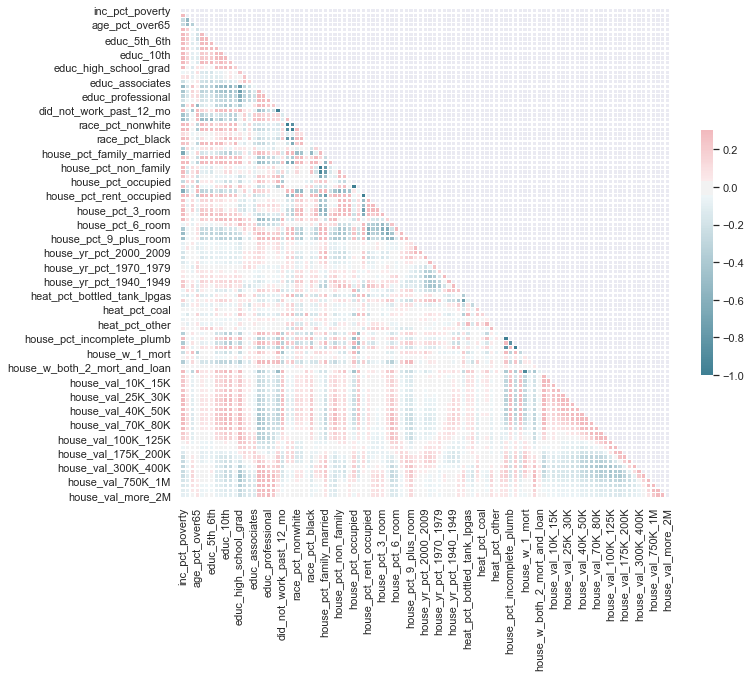

In [65]:
# Find correlated features in ACS dataset and identify the highly correlated relationships

# Based on feature importance experiments, select features with consistence importance across annual predictions

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))

# From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh'], axis=1) 

# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS = ACS[['house_yr_pct_earlier_1939', 'house_pct_occupied', 'house_pct_family_married', 'race_pct_black',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad', 'house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_175K_200K',
           'house_val_200K_250K']]


In [66]:
# Function to upsample or downsample our dataframe features if we have unbalanced classes

def resample_df(X,y,upsample=True,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    # Add Class feature to dataframe equal to our existing dependent variable
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    

    if upsample:      
    
        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0], 
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        #print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       #df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        #print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      #df_major_resampled.shape[0]))


    
    
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1)
    return X_out , y_out

In [67]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_model(top10,fires, ACS = pd.DataFrame(), nyears = 4, modeltype='LogisticRegression', resample = False, seed = SEED):
    from scipy.stats import zscore
    
    
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                            random_state = 0)
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
            # based on the specific number of previous years' data
        
    years = top10.columns
    
    
    start_pointer = 0
    end_pointer = nyears-1
    y_pointer = nyears
    while y_pointer < len(years):
        X_start, X_end = start_pointer, end_pointer
       
        X = fires.iloc[:,X_start:X_end].copy()
            
        L = X.shape[1] 
        X.columns = ['year-{}'.format(L - year) for year in range(L)]
        
        sm = np.sum(X, axis = 1 )
        mu = np.mean(X, axis = 1)
        mx = np.max(X, axis =1)
        X['Sum']  = sm
        X['Mean'] = mu
        X['Max']  = mx
        y = top10.iloc[:,y_pointer]
    
        # merge in ACS Data into X unless NFIRS-Only model
        if not ACS.empty:
            X=X[['Sum','Mean','Max']] # drop all other NFIRS columns that have low feature importance scores
            X = X.merge(ACS, how ='left',left_index = True, right_index = True)
            X = X.dropna()
            y = y.filter(X.index)
        
        
        
        # Create 80/20 training/testing set split
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )
        
        # Perform resampling if data classes are unbalanced
        if resample:
            X_train, y_train = resample_df(X_train,y_train)
    
    
        # Perform cross-validation 
        
        #scaler = preprocessing.StandardScaler().fit(X)
        #scaler.transform(X)
        #print ('Cross Val Score:')
        #print(cross_val_score(model, X, y))
        
        
        # Standardize features by removing the mean and scaling to unit variance
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        scaler.transform(X_train)
        scaler.transform(X_test)
        
        
        # Fit model to training set
        
        print('Predicting {}:'.format(years[y_pointer]) )
        model = model.fit(X_train,y_train)

        
        # Calculate training set performance
        
        train_prediction_probs = model.predict_proba(X_train)
        train_predictions = model.predict(X_train)
        print (confusion_matrix(y_train, train_predictions))
        print (roc_auc_score(y_train, train_prediction_probs[:,1]))
        
        
        # Calculate test set performance
        
        test_prediction_probs = model.predict_proba(X_test)
        test_predictions = model.predict(X_test)
        print (confusion_matrix(y_test, test_predictions))
        print (roc_auc_score(y_test, test_prediction_probs[:,1]))
        print (classification_report(y_test,test_predictions))
        print (log_loss(y_test,test_predictions))
        
        
        #Calculate feature importance for each model
        
        if modeltype=="LogisticRegression":
            feature_importance = {}
            for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
                feature_importance[feat] = coef
            print("Feature ranking:")
            print (feature_importance)
        else:
            if modeltype=="RF" or modeltype=="BalRF":
                importances = model.feature_importances_
            elif modeltype=="Bagged":
                importances = np.mean([model.estimators_[i].feature_importances_ for i 
                               in range(len(model.estimators_))], axis=0)
            elif modeltype=="BalBagged":
                importances = np.mean([model.estimators_[i].steps[1][1].feature_importances_ for i 
                               in range(len(model.estimators_))], axis=0)
        
            indices = np.argsort(importances)[::-1]
            print("Feature ranking:")
            for f in range(len(X_test.columns)):
                print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))
        
        # Increment sliding prediction window
        #start_pointer += 1
        end_pointer += 1
        y_pointer += 1
    
    
            
    return model,X_test,y_test
        


In [68]:
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl,X_test,y_test =train_model(top10.loc[:,'2009':'2016'],fires,ACS = ACS,nyears=5, modeltype='BalRF',resample = False)

Predicting 2014:
[[42592  7763]
 [  782  4819]]
0.9322352202770436
[[10645  1990]
 [  235  1119]]
0.9146044579691474
              precision    recall  f1-score   support

       False       0.98      0.84      0.91     12635
        True       0.36      0.83      0.50      1354

    accuracy                           0.84     13989
   macro avg       0.67      0.83      0.70     13989
weighted avg       0.92      0.84      0.87     13989

5.4936284707672005
Feature ranking:
1. Max (0.741986)
2. Sum (0.058691)
3. Mean (0.051676)
4. house_pct_family_married (0.024255)
5. race_pct_black (0.024028)
6. house_yr_pct_earlier_1939 (0.023576)
7. house_pct_occupied (0.015218)
8. house_pct_ownd_occupied (0.008656)
9. worked_past_12_mo (0.008533)
10. heat_pct_fueloil_kerosene (0.008095)
11. house_val_175K_200K (0.007126)
12. house_val_200K_250K (0.006669)
13. house_pct_live_alone (0.006556)
14. educ_bachelors (0.005914)
15. educ_some_col_no_grad (0.004639)
16. house_w_home_equity_loan (0.004381)


In [36]:
# Function to visualize relative feature importance for trained Logistic Regression models
def plot_LR_feat_importance(model):
    # Calculate and store relative importance of model features
    feature_importance = {}
    for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
        feature_importance[feat] = coef
    data_to_plot = pd.DataFrame.from_dict(features,orient ='index').reset_index()
    data_to_plot.columns = ['Variables','Importance Coefficients']
    data_to_plot = data_to_plot.sort_values('Importance Coefficients', ascending=False )
    data_to_plot = data_to_plot[0:10]

    plt.figure(figsize=(16, 8))
    sns.barplot(
        x='Variables', y='Importance Coefficients',
        data=data_to_plot, palette='Blues_r')
    plt.xticks(
        range(len(data_to_plot)),
        data_to_plot['Variables'], rotation='45', size=10)
    plt.xlabel('Variables', fontsize=30)
    plt.ylabel('Coeff', fontsize=30)
    plt.tight_layout()
    plt.show()
    
    
# Display list of relative feature importance for RF models
def rf_feat_importance(model, num_feats_to_display):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(num_feats_to_display):
        print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

        
# Function to visualize example tree from random forest (only functional if model max_depth<=5)
def plot_rf_tree(model):
    estimator = model.estimators_[1]
    from sklearn import tree
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
    tree.plot_tree(estimator,
               feature_names = X_test.columns, 
               class_names=y_test.index.name,
               filled = True);
    fig.savefig('rf_individualtree.png')

In [18]:
def plot_boundaries(X,y,model,n):
        
    from itertools import combinations
    n_elms = max(y.shape[0],1000) # only plot 1000 elements from each class
    
    n_cols = np.ceil(np.sqrt(n))
    n_rows = np.ceil(n / n_cols)

    names = X.columns
    combos = [c for c in combinations(range(X.shape[1]), 2) ]
    
    W = model.coef_[0]
        

    b = model.intercept_
    
    for c in enumerate(combos[:n]):
        x_idx = c[1][0]
        y_idx = c[1][1]
        plot_num = c[0]
            
            
        print('subplot{} {}: {}'.format(n_rows,n_cols,c[0]))
        plt.subplot(n_rows,n_cols,c[0]+1)
        plt.scatter(X.iloc[:n_elms, x_idx],
                    X.iloc[:n_elms, y_idx],
                    c=y[:n_elms], edgecolors='k',
                    alpha = .3, cmap=plt.cm.binary)
        
        ax = plt.gca()

        x_values = np.array(ax.get_xlim())
        y_values = -(b + np.dot(W[x_idx],x_values)) / W[y_idx]

        plt.plot(x_values, y_values )


        plt.xticks(())
        plt.xlabel(names[x_idx])
        plt.yticks(())
        plt.ylabel(names[y_idx])
    plt.show()

    
    
    
    
    
    
    

subplot2.0 2.0: 0


/Users/felixbartsch/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:278: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/Users/felixbartsch/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:278: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


ValueError: RGBA values should be within 0-1 range

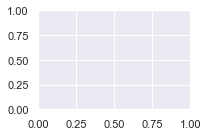

In [19]:
plot_boundaries(fires,top10,mdl,4)